<a href="https://colab.research.google.com/github/ecandes/stat318/blob/master/Swendsen_Wang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling from the Ising model via the Swendsen-Wang and Wolff algorithm

We set 

$$
\text{Temperature} = 0.8 T_c
$$

In [89]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random

plt.rcParams["figure.figsize"] = (6,6)

# helper func to set seeds
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

We work with the square lattice for our graph $G$ represented below. 

In [220]:
# plotting setup
plt.rcParams["figure.figsize"] = (6,6)
L = 64
options = {'node_size': 5, 'alpha' : 1, 'width' : 0.5}

In [236]:
set_seed(1)

class IsingModel:

    def __init__(self, G, X=None):
        self.G = G                   # Underlying graph
        self.n = G.number_of_nodes()  # Number of nodes
        self.nodes = list(G.nodes.keys())  # List of nodes
        if X is None:
            X = np.ones(self.n).astype(int)
        self.X = dict(zip(self.nodes, X))
        # Useful for plotting
        self.pos = dict(zip(self.nodes, self.nodes))

    def randomBit(self,p):
        return np.random.binomial(1, p, size=1)[0]
    
    def randomNode(self):
        return self.nodes[np.random.randint(0,self.n)]
    
    def addBond(self,v1,v2,beta):
        return (self.X[v1] == self.X[v2] and self.randomBit(1-np.exp(-2*beta)) == 1)

    def updateBonds(self,beta):
        ebonds = []
        for e in self.G.edges:
            if self.addBond(e[0],e[1],beta):
                ebonds.append(e) 
        return ebonds 
    
    def removeEdges(self,p):
        """p is probability of keeping the edge"""
        nedges = self.G.number_of_edges()
        U = np.random.rand(nedges) > p
        ebunch = [e for e,u in zip(self.G.edges,U) if u]
        self.G.remove_edges_from(ebunch)
        
#     def getCluster(self,v0,beta):
#         ebunch = []
#         nbunch = [v for v in nx.node_connected_component(self.G, v0) if self.X[v0]==self.X[v]]
#         for e in self.G.edges(nbunch):
#             if self.addBond(e[0],e[1],beta):
#                 ebunch.append(e) 
#         G = nx.Graph()
#         G.add_nodes_from(nbunch)
#         G.add_edges_from(ebunch)
#         return nx.node_connected_component(G,v0)
        
    def updateSpins(self,beta,method='sw'):
        ebonds = self.updateBonds(beta)
        G = nx.Graph()
        G.add_nodes_from(self.G)
        G.add_edges_from(ebonds)
        if method == 'sw':
            for c in nx.connected_components(G):
                val = 2*self.randomBit(1/2)-1
                for v in c:
                    self.X[v] = val
        elif method == 'wolff':
            flip = {1:-1, -1:1}
            v0 = self.randomNode()
            val = flip[self.X[v0]]
#             for v in self.getCluster(v0,beta):
            for v in nx.node_connected_component(G, v0):
                self.X[v] = val
                
    def sum(self):
        return np.array(list(self.X.values())).sum()
  
    def drawConfig(self, node_size=5):
        plt.rcParams["figure.figsize"] = (6,6)
        up = [key for key in self.X.keys() if self.X[key] == 1]
        down = [key for key in self.X.keys() if self.X[key] == -1]
        nx.draw(G, self.pos, nodelist=up,   node_color="lightcoral",
                **options)
        nx.draw(G, self.pos, nodelist=down, node_color="slateblue", 
                **options)
        plt.title('Ising model configuration')
        plt.show()

    def sample(self, T, beta =1, method='sw', X0=None):
        if not X0 is None:
            self.X = X0
        for t in range(T):
            self.updateSpins(beta, method)
                   

## Drawing one sample

Let us check a sample after 100 iterations.

In [242]:
beta_crit = np.log(1+np.sqrt(2))
beta = 1.25*beta_crit
T = 100

In [243]:
%%time 
set_seed(1)

chain = IsingModel(nx.grid_2d_graph(L,L))
chain.sample(T,beta,'sw')
chain.drawConfig()
print('Magnetization at T = {}: {}'.format(T,chain.sum()))

Magnetization at T = 100: 4088
CPU times: user 13.2 s, sys: 150 ms, total: 13.3 s
Wall time: 12.8 s


In [244]:
set_seed(1)

chain = IsingModel(nx.grid_2d_graph(L,L))
chain.sample(T,beta,'wolff')
chain.drawConfig()
print('Magnetization at T = {}: {}'.format(T,chain.sum()))

Magnetization at T = 100: 4094


## Calculating magnetization over 100 samples

We are interested in the distribution of the magnetization $M$ defined as 

$$
M =  f(x) = \sum_v x_v.
$$

We generate a number of samples by running the chain and getting a realization every $T = 100$ time steps. 




In [245]:
set_seed(1)

def empiricalMagnetization(beta=1,T=100,nsamples=500, method='sw'):
    chain = IsingModel(nx.grid_2d_graph(L,L))
    magnetization = np.zeros(nsamples)
    for b in range(nsamples):
        chain.sample(T,beta,method)
        magnetization[b] = chain.sum()  
    plt.rcParams["figure.figsize"] = (6,6)
    plt.hist(magnetization)
    plt.title('Magnetization')
    plt.show()
    return magnetization

In [247]:
%%time
set_seed(1)

magnetization = empiricalMagnetization(beta=beta, T=100, nsamples=100, method='sw')

KeyboardInterrupt: 

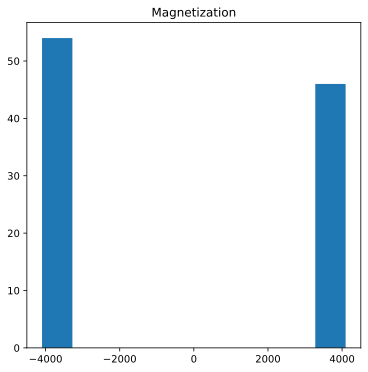

CPU times: user 16min 27s, sys: 6.6 s, total: 16min 34s
Wall time: 16min 34s


In [238]:
%%time
set_seed(1)

magnetization = empiricalMagnetization(beta=beta, T=100, nsamples=100, method='wolff')